In [2]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import statsmodels.stats.multitest as multi
from scipy.stats import pearsonr
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from matplotlib.ticker import MaxNLocator

In [3]:
input_path = "/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/"
output_path = "./circRNA_shap_output"
if not (os.path.exists(output_path)):
    os.mkdir(output_path)

# load kmer file
df_kmer_345 = pd.read_csv(os.path.join(input_path,"train_kmer345_freq.tsv"),sep='\t',index_col= 0)
transcript_id = df_kmer_345['RNA_Symbol']
# convert to x:kmer-freq , y:label
del df_kmer_345['RNA_Symbol']
x_kmer = df_kmer_345.values
y_kmer = np.array(df_kmer_345.index)

# load model
circExor = joblib.load('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/RandomForest/best_RandomForest_model.pkl')

df_kmer_345.columns

Index(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC',
       ...
       'TTTCG', 'TTTCT', 'TTTGA', 'TTTGC', 'TTTGG', 'TTTGT', 'TTTTA', 'TTTTC',
       'TTTTG', 'TTTTT'],
      dtype='object', length=1344)

In [4]:
shap.initjs() 
# Interpret the model's predictions on the entire dataset for nuclear/cytosol localization 
circExor_explainer = shap.TreeExplainer(circExor)

shap_values_circExor = circExor_explainer.shap_values(df_kmer_345)

# 检查shap_values的形状
print(f"SHAP values shape: {np.array(shap_values_circExor).shape}")

# 对于二分类问题，通常只需要正类（类别1）的SHAP值
if isinstance(shap_values_circExor, list):
    # 如果是列表形式，取第二个元素（正类）
    shap_values_positive = shap_values_circExor[1]
else:
    # 如果是3D数组，取第三维的索引1（正类）
    shap_values_positive = shap_values_circExor[:, :, 1]

# Convert to dataframe with column names
shap_df = pd.DataFrame(shap_values_positive, columns=df_kmer_345.columns)
shap_df.index = transcript_id 
shap_df.to_csv(os.path.join(output_path, "circRNA_shap_df.txt"), sep='\t')

# Mean(abs(shap_value))
mean_abs_shap_val = shap_df.apply(lambda x: abs(x).mean(), axis=0)
mean_abs_shap_val.to_csv(os.path.join(output_path, "circRNA_mean_abs_shap.txt"), sep='\t')

print(f"SHAP DataFrame shape: {shap_df.shape}")
print("SHAP analysis completed!")

SHAP values shape: (1098, 1344, 2)
SHAP DataFrame shape: (1098, 1344)
SHAP analysis completed!


In [5]:
mean_abs_shap_val 

AAA      0.000425
AAC      0.000501
AAG      0.000243
AAT      0.000452
ACA      0.000280
           ...   
TTTGT    0.001073
TTTTA    0.001229
TTTTC    0.000090
TTTTG    0.000408
TTTTT    0.001189
Length: 1344, dtype: float64

In [6]:
# Calculate pearson correlation
lnc_num = shap_df.shape[0]
total_df = pd.concat([df_kmer_345,shap_df])
total_df

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.006718,0.008398,0.008188,0.003989,0.006928,0.005879,0.002519,0.003779,0.006299,0.008398,...,0.000000,0.000630,0.000210,4.199034e-04,0.000630,0.000210,2.099517e-04,0.000420,0.000210,0.000000
1,0.006633,0.003317,0.006633,0.001658,0.004975,0.004975,0.000000,0.006633,0.009950,0.008292,...,0.000000,0.001658,0.000000,1.658375e-03,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
0,0.007582,0.005352,0.006467,0.007805,0.007247,0.004906,0.000892,0.005240,0.008362,0.004683,...,0.000223,0.000669,0.000557,4.459806e-04,0.000446,0.001226,1.226447e-03,0.000334,0.002007,0.001115
0,0.006434,0.003262,0.010059,0.003715,0.005256,0.005347,0.002537,0.003444,0.008790,0.010150,...,0.000181,0.000181,0.000181,4.531038e-04,0.000634,0.000272,0.000000e+00,0.000091,0.000544,0.000181
0,0.003376,0.003376,0.005402,0.004727,0.005402,0.006752,0.002026,0.003376,0.006752,0.002701,...,0.000000,0.001350,0.001350,0.000000e+00,0.001350,0.000675,0.000000e+00,0.001350,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa_circ_0002490,-0.000302,-0.000362,-0.000018,-0.000018,-0.000035,-0.000474,-0.000320,-0.000792,0.000069,-0.000330,...,-0.000206,0.000020,-0.000035,-4.718101e-05,-0.000193,-0.000466,-9.717200e-04,-0.000030,0.000042,-0.001100
hsa_circ_0000610,0.000312,-0.000196,-0.000325,0.001098,-0.000267,-0.001363,-0.000414,-0.001485,0.000826,0.000053,...,-0.000097,-0.000150,-0.000001,-3.324625e-05,-0.000040,-0.000419,-8.326078e-04,-0.000034,-0.000056,-0.000120
hsa_circ_0002474,0.000435,-0.000247,0.000113,-0.000472,-0.000256,0.000839,-0.000232,-0.000032,0.000023,0.000727,...,-0.000132,0.001595,0.000254,1.278728e-05,0.000661,-0.000772,-7.340661e-04,-0.000025,-0.000302,-0.000914
hsa_circ_0077833,0.000086,-0.000091,0.000149,-0.000208,0.000220,-0.000693,-0.000988,-0.000406,0.001591,-0.000195,...,-0.000184,0.000397,-0.000085,4.887945e-07,-0.000544,-0.000470,-4.563471e-07,-0.000116,-0.000260,-0.000602


In [7]:
# Pearson correlation coefficient (r and p_value)
total_df = total_df.replace([np.inf, -np.inf], np.nan)
total_df = total_df.fillna(total_df.mean())
pearsonr_r = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[0],axis=0)
pearsonr_p = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[1],axis=0)
fdr =pd.Series(multi.multipletests(pearsonr_p)[1],index = pearsonr_p.index)

# Merge to kmer_info ["mean_abs_shap","pearsonr_r","pearsonr_p","fdr"]
kmer_info_df = pd.concat([mean_abs_shap_val,pearsonr_r,pearsonr_p,fdr],axis=1) 
kmer_info_df.columns = ["mean_abs_shap","pearsonr_r","pearsonr_p","fdr"]

kmer_info_df.to_csv(os.path.join(output_path,"kmer_importance_quantification_info.txt"),sep='\t')
kmer_info_df

/tmp/ipykernel_129640/3725946013.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_r = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[0],axis=0)
/tmp/ipykernel_129640/3725946013.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_p = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[1],axis=0)


,mean_abs_shap,pearsonr_r,pearsonr_p,fdr
AAA,0.000425,0.054733,6.984029e-02,9.932637e-01
AAC,0.000501,-0.137856,4.545904e-06,9.632696e-04
AAG,0.000243,0.405544,1.019388e-44,6.880871e-42
AAT,0.000452,-0.187473,3.834571e-10,1.085184e-07
ACA,0.000280,0.168822,1.821142e-08,4.771380e-06
...,...,...,...,...
TTTGT,0.001073,0.712826,4.644321e-171,5.879710e-168
TTTTA,0.001229,0.737510,4.657460e-189,6.012781e-186
TTTTC,0.000090,0.539147,8.147296e-84,7.609574e-81
TTTTG,0.000408,0.331777,1.268480e-29,6.748312e-27


Top 20 features: ['CGGA', 'TCAAG', 'CACCA', 'TAG', 'TGACC', 'TCTAC', 'TAGA', 'GTCC', 'GTC', 'CCG', 'CGA', 'TACG', 'AGTCC', 'CCAAG', 'CGGAA', 'CTCAA', 'ATTT', 'GAGAG', 'CGAC', 'ACC']
Feature frequencies shape: (1098, 20)
SHAP values shape: (1098, 20)


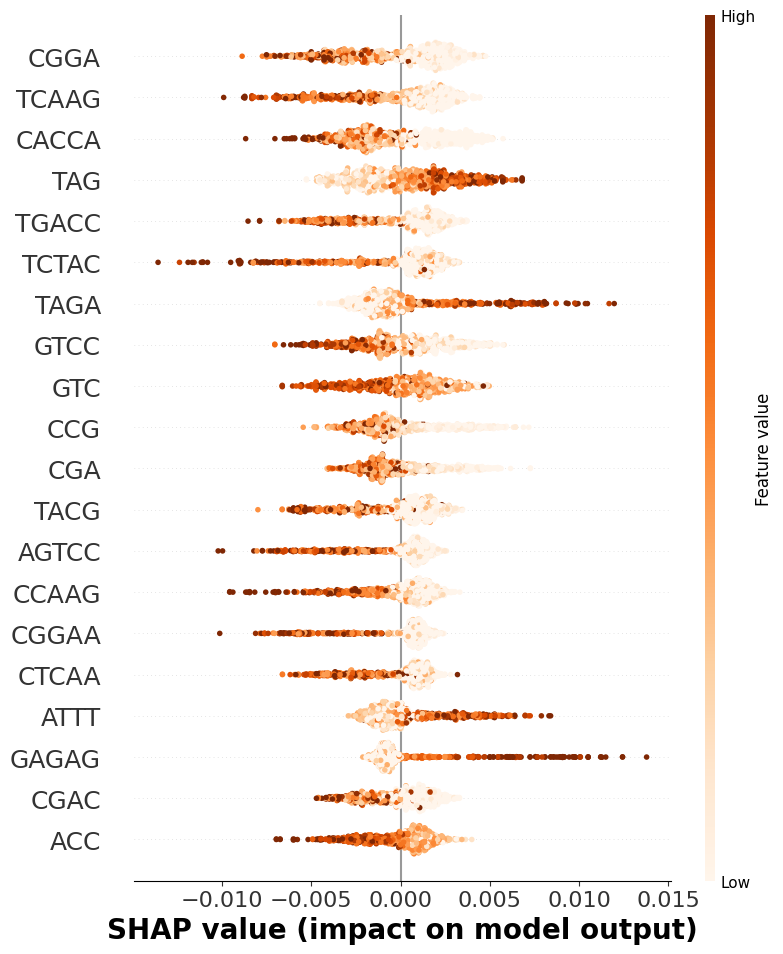

In [ ]:
# 使用现有的 df_kmer_345 和 shap_df 绘制SHAP总结图

# 转换SHAP值为numpy数组
shap_values_array = shap_df.values

# 计算特征重要性（基于SHAP值绝对值的平均）
feature_importance = np.abs(shap_values_array).mean(axis=0)

# 获取top 20特征的索引（按重要性降序排列）
top_20_indices = np.argsort(feature_importance)[-20:][::-1]

# 提取top 20特征的数据
top_20_features_freq = df_kmer_345.iloc[:, top_20_indices]  # 特征频率
top_20_shap_values = shap_values_array[:, top_20_indices]   # 对应的SHAP值
top_20_feature_names = df_kmer_345.columns[top_20_indices]   # 特征名称

print(f"Top 20 features: {list(top_20_feature_names)}")
print(f"Feature frequencies shape: {top_20_features_freq.shape}")
print(f"SHAP values shape: {top_20_shap_values.shape}")

# 设置颜色映射
my_colormap = plt.get_cmap("Oranges")

# 绘制SHAP总结图
plt.figure(figsize=(8, 9))  # 设置图形大小
shap.summary_plot(
    top_20_shap_values,
    features=top_20_features_freq,
    feature_names=top_20_feature_names,
    max_display=20,
    show=False,
    cmap=my_colormap
)

# 调整颜色映射
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_colormap)

# 获取当前轴对象并调整字体大小
ax = plt.gca()

# 调整X轴和Y轴刻度字体大小
ax.tick_params(axis='x', labelsize=16)  # X轴刻度字体大小
ax.tick_params(axis='y', labelsize=18)  # Y轴刻度字体大小

# 调整X轴和Y轴标签字体大小
ax.set_xlabel(ax.get_xlabel(), fontsize=20, fontweight='bold')  # X轴标签字体大小
ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold')  # Y轴标签字体大小


# 保存图片
plt.savefig(os.path.join(output_path, "SHAP_total_top20_kmer.pdf"), format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

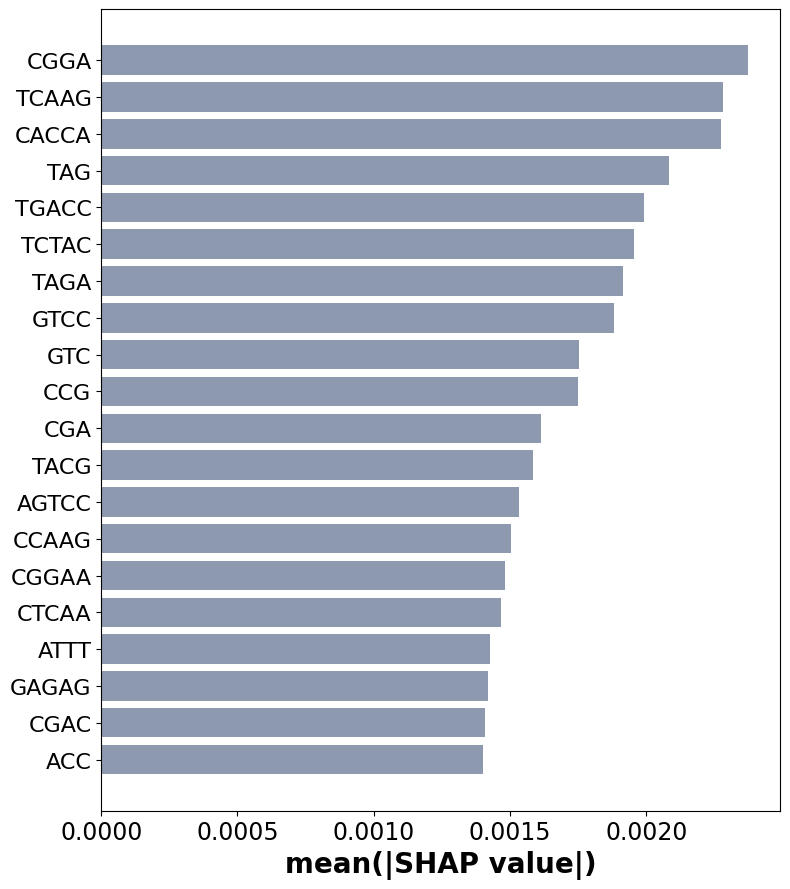

In [29]:
# 使用 mean_abs_shap_val 绘制 TOP k-mer 的平均绝对 SHAP 值柱状图

# 获取 TOP 20 特征
top_20_features = mean_abs_shap_val.nlargest(20)

# 创建柱状图
plt.figure(figsize=(8, 9))
bars = plt.barh(range(len(top_20_features)), 
                top_20_features.values[::-1],  # 反转数值顺序，使最大值在顶部
                color="#8d99ae")

# 设置 y 轴标签（反转特征名称顺序）
plt.yticks(range(len(top_20_features)), top_20_features.index[::-1])
plt.tick_params(axis='x', labelsize=17)  # X轴刻度字体大小
plt.tick_params(axis='y', labelsize=16)  # Y轴刻度字体大小

# 设置标签和标题
plt.xlabel('mean(|SHAP value|)', fontsize=20, fontweight='bold')
# plt.ylabel('Feature')
# plt.title('SHAP Feature Importance (Top 20)')

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig(os.path.join(output_path, "SHAP_total_top20_kmer_bar.pdf"), format='pdf', dpi=1200)
plt.show()

/tmp/ipykernel_129640/201839086.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='kmer_length', y='mean_abs_shap', data=df, palette=chosen_color)  # 横纵调换


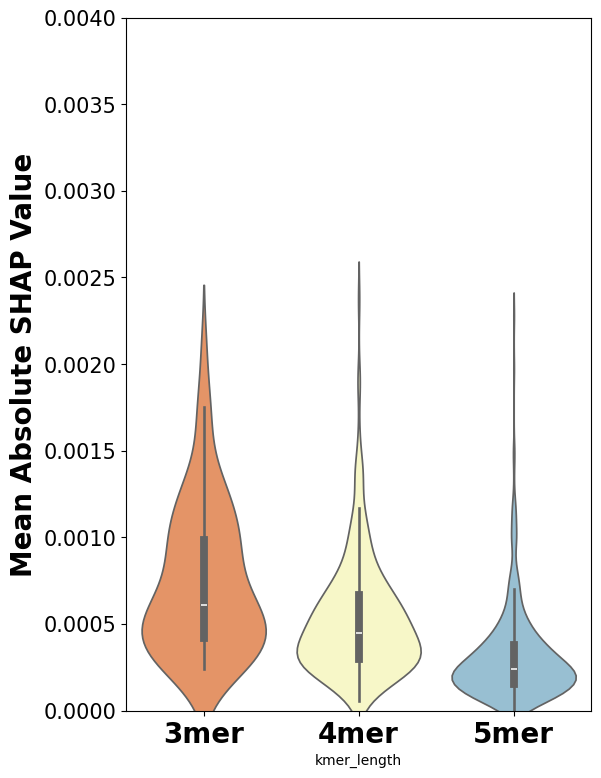

4.22103984484377e-05 4.394951903844816e-35 5.110359962356961e-22


In [ ]:
# 多重检验矫正版本
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 数据准备
# -----------------------------
abs_shape_3mer = mean_abs_shap_val[mean_abs_shap_val.index.str.len() == 3]
abs_shape_4mer = mean_abs_shap_val[mean_abs_shap_val.index.str.len() == 4]
abs_shape_5mer = mean_abs_shap_val[mean_abs_shap_val.index.str.len() == 5]

print(f"Number of 3-mer features: {len(abs_shape_3mer)}")
print(f"Number of 4-mer features: {len(abs_shape_4mer)}")
print(f"Number of 5-mer features: {len(abs_shape_5mer)}")

df = pd.DataFrame({
    'mean_abs_shap': pd.concat([abs_shape_3mer, abs_shape_4mer, abs_shape_5mer]),
    'kmer_length': ['3mer'] * len(abs_shape_3mer) + ['4mer'] * len(abs_shape_4mer) + ['5mer'] * len(abs_shape_5mer)
})

# -----------------------------
# 绘制小提琴图
# -----------------------------
plt.figure(figsize=(6, 9))
sns.violinplot(x='kmer_length', y='mean_abs_shap', data=df, palette="RdYlBu")
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=15)
plt.ylabel('Mean Absolute SHAP Value', fontsize=20, fontweight='bold')
plt.ylim(0, 0.004)
plt.savefig('mean_abs_shap_violin_plot_corrected.pdf', format='pdf', dpi=1200)
plt.show()

# -----------------------------
# Kruskal-Wallis总体检验
# -----------------------------
kw_stat, kw_p = kruskal(abs_shape_3mer, abs_shape_4mer, abs_shape_5mer)
print("Overall Kruskal-Wallis test:")
print(f"Statistic={kw_stat:.4f}, p-value={kw_p:.4e}")

# -----------------------------
# 两两比较 + 多重校正
# -----------------------------
comparisons = [
    ("3mer vs 4mer", abs_shape_3mer, abs_shape_4mer),
    ("4mer vs 5mer", abs_shape_4mer, abs_shape_5mer),
    ("3mer vs 5mer", abs_shape_3mer, abs_shape_5mer)
]

raw_pvals = []
stats = []
labels = []

for name, g1, g2 in comparisons:
    stat, p = kruskal(g1, g2)
    raw_pvals.append(p)
    stats.append(stat)
    labels.append(name)

# 多重校正（Benjamini-Hochberg FDR）
reject, qvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

# -----------------------------
# 输出结果表
# -----------------------------
results_df = pd.DataFrame({
    'Comparison': labels,
    'Kruskal_Statistic': stats,
    'Raw_p_value': raw_pvals,
    'Adjusted_q_value': qvals,
    'Significant(FDR<0.05)': reject
})
print("\nPairwise Kruskal-Wallis comparisons with FDR correction:")
print(results_df.to_string(index=False))



In [11]:
TOP40_SHAP_kmer = kmer_info_df.sort_values(by = 'mean_abs_shap', ascending=False).head(n = 40)

kmer_info_df['abs_pearsonr'] = kmer_info_df['pearsonr_r'].abs()
TOP20_pearsonr_kmer = kmer_info_df.sort_values(by = 'abs_pearsonr', ascending=False).head(n = 20)
common_index = TOP40_SHAP_kmer.index.intersection(TOP20_pearsonr_kmer.index)
common_index

Index(['CCAAG', 'GAGAG', 'GGGT', 'TTTTT'], dtype='object')

In [12]:
kmer_info_df

,mean_abs_shap,pearsonr_r,pearsonr_p,fdr,abs_pearsonr
AAA,0.000425,0.054733,6.984029e-02,9.932637e-01,0.054733
AAC,0.000501,-0.137856,4.545904e-06,9.632696e-04,0.137856
AAG,0.000243,0.405544,1.019388e-44,6.880871e-42,0.405544
AAT,0.000452,-0.187473,3.834571e-10,1.085184e-07,0.187473
ACA,0.000280,0.168822,1.821142e-08,4.771380e-06,0.168822
...,...,...,...,...,...
TTTGT,0.001073,0.712826,4.644321e-171,5.879710e-168,0.712826
TTTTA,0.001229,0.737510,4.657460e-189,6.012781e-186,0.737510
TTTTC,0.000090,0.539147,8.147296e-84,7.609574e-81,0.539147
TTTTG,0.000408,0.331777,1.268480e-29,6.748312e-27,0.331777


In [13]:
def save_kmers_to_fasta(kmers, filename, prefix="kmer"):
    """
    将kmer列表保存为FASTA文件
    
    参数:
    kmers: kmer列表
    filename: 输出文件名
    prefix: 序列名前缀
    """
    with open(filename, 'w') as f:
        for i, kmer in enumerate(kmers, 1):
            # 写入序列头
            f.write(f">{prefix}_{i}\n")
            # 写入序列
            f.write(f"{kmer}\n")

# 第一组kmer
kmers1 = ['CGGA',
 'TCAAG',
 'CACCA',
 'TGACC',
 'TCTAC',
 'GTCC',
 'GTC',
 'CCG',
 'CGA',
 'TACG',
 'AGTCC',
 'CCAAG',
 'CGGAA',
 'CTCAA',
 'CGAC',
 'ACC',
 'ACCT',
 'CAC',
 'CCCT',
 'GACC',
 'GCTGA',
 'CGT',
 'GCGG',
 'TCC',
 'AGCTC',
 'AAGGT',
 'CGAG',
 'CAGCA']

# 第二组kmer
kmers2 = ['TAG',
 'TAGA',
 'ATTT',
 'GAGAG',
 'GGGT',
 'TTTTA',
 'GTA',
 'GAG',
 'TAA',
 'TTTTT',
 'TAGCT',
 'ATT']

# 保存为FASTA文件
save_kmers_to_fasta(kmers1, "cyto_kmers.fasta", "cyto")
save_kmers_to_fasta(kmers2, "EV_kmers.fasta", "EV")



In [14]:
TOP40_SHAP_kmer = kmer_info_df.sort_values(by = 'mean_abs_shap', ascending=False).head(n = 40)
TOP40_SHAP_kmer[(TOP40_SHAP_kmer['pearsonr_r'] < 0)].index.tolist()

['CGGA',
 'TCAAG',
 'CACCA',
 'TGACC',
 'TCTAC',
 'GTCC',
 'GTC',
 'CCG',
 'CGA',
 'TACG',
 'AGTCC',
 'CCAAG',
 'CGGAA',
 'CTCAA',
 'CGAC',
 'ACC',
 'ACCT',
 'CAC',
 'CCCT',
 'GACC',
 'GCTGA',
 'CGT',
 'GCGG',
 'TCC',
 'AGCTC',
 'AAGGT',
 'CGAG',
 'CAGCA']

In [15]:
TOP40_SHAP_kmer = kmer_info_df.sort_values(by = 'mean_abs_shap', ascending=False).head(n = 40)
TOP40_SHAP_kmer[(TOP40_SHAP_kmer['pearsonr_r'] > 0)].index.tolist()

['TAG',
 'TAGA',
 'ATTT',
 'GAGAG',
 'GGGT',
 'TTTTA',
 'GTA',
 'GAG',
 'TAA',
 'TTTTT',
 'TAGCT',
 'ATT']